In [13]:
%load_ext autoreload

In [25]:
%autoreload
import matplotlib.pyplot as plt
from nn_tools import *

from torch.utils.data import Dataset, DataLoader

from torch.utils.data.sampler import SubsetRandomSampler as rand_sampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torchvision import transforms, datasets

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device in use: {device}")

seed = 69420

torch.manual_seed(seed)

Training device in use: cpu


SAMPLE AT INDEX 125
LABEL: 2


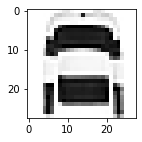

In [26]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomInvert(p=0.5),
        ]) 

train_dataset = datasets.FashionMNIST('classifier_data', train=True, download=True, transform = transform)
test_dataset  = datasets.FashionMNIST('classifier_data', train=False, download=True, transform = transform)

n_train = int(len(train_dataset)/5)
n_test = int(len(test_dataset))

split_idx = int(0.75*n_train)
train_samples = rand_sampler(list(range(n_train))[:split_idx])
val_samples = rand_sampler(list(range(n_train))[split_idx:])

train_dataloader = DataLoader(train_dataset, sampler = train_samples, batch_size = 300, num_workers = 0)
val_dataloader = DataLoader(train_dataset, sampler = val_samples, batch_size = n_train - split_idx, num_workers = 0)

test_dataloader = DataLoader(test_dataset, batch_size = None, shuffle = True, num_workers = 0)

sample_index = 125
image = train_dataset[sample_index][0].squeeze()
label = train_dataset[sample_index][1]

fig = plt.figure(figsize=(2,2))
plt.imshow(image, cmap='Greys')
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")

img_shape = tuple(image.shape)
no_labels = len(np.unique(train_dataset.targets))

In [27]:
class CNN2D(data_API):
    
    def __init__(self, device, in_side, conv1_filters, k_size1, conv2_filters, k_size2, Nd1, Nd2, N_labels):
        """
        device - device used for computing
        in_side - side length of the square images to classify
        conv1_filters - no of filters in the first convolutional layer
        k_size1 - kernel size of each filter in conv1
        conv2_filters - no of filters in the second convolutional layer
        k_size2 - kernel size of each filter in conv2
        Nh1 - Neurons in the 2nd dense layer (first layer 
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__(device)
        super().train_model

        self.conv_shape = self.no_params_conv(
                self.no_params_conv(
                    self.no_params_conv(self.no_params_conv(in_side, k_size1, 0, 1),2, 0, 1),
                    2, 0, 1),
                k_size2, 0, 1)
        self.dropout = nn.Dropout(p = 0.4)
        
        self.model = nn.Sequential(
            nn.Conv2d(1, conv1_filters, k_size1), nn.ReLU(),
            nn.MaxPool2d(2, stride = 1),
            nn.Conv2d(conv1_filters, conv2_filters, k_size2), nn.ReLU(),
            nn.MaxPool2d(2, stride = 1),
            nn.Flatten(),
            nn.Linear(in_features=conv2_filters*self.conv_shape**2, out_features=Nd1), nn.ReLU(),
            nn.Linear(in_features=Nd1, out_features=Nd2), nn.ReLU(),
            nn.Linear(in_features=Nd2, out_features=N_labels)
        )

        print("Network initialized")
        
    def forward(self, x, additional_out=False):
        return self.model(x)

    def no_params_conv(self, in_size, kernel, padding, stride):
        """
        Finds no of parameters per channel after every convolution/pooling
        """
        return int((in_size - kernel + 2*padding)/stride + 1)

    def accuracy(self, dataset):

        dataloader = DataLoader(test_dataset, batch_size = 1, shuffle = False, num_workers = 0)
        n_samples = dataloader.__len__()
        n_correct = 0

        self.eval()
        with torch.no_grad():
            for data in dataloader:
                x_sample = data[0].to(self.device)
                label = data[1].to(self.device)
                out = self(x_sample)
                out = F.softmax(out, dim = 1)
                if (((out[0] == out.max()).nonzero() == label).squeeze()).item() == True:
                    n_correct += 1
        return n_correct/n_samples

In [5]:
cnn = CNN2D(device, 28, 3, 6, 4, 3, 17, 16, no_labels)
cnn.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr = 0.001)

Network initialized


In [16]:
num_epochs = 10
cnn.train_model(train_dataloader, num_epochs, loss_fn, optimizer, val_loader = val_dataloader)

torch.save(cnn, f'CNN_fashionMNIST_{num_epochs}_epochs.pt')

In [28]:
cnn = torch.load('CNN_model.pt')

In [29]:
test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle = True, num_workers = 0)
test_accuracy = cnn.accuracy(test_dataloader)
print(f"Accuracy on test set: {test_accuracy*100:.3f}%")

Accuracy on test set: 74.720%


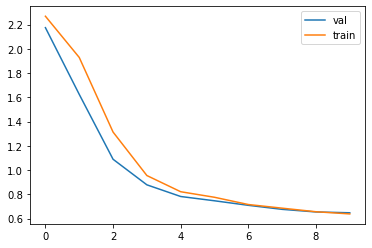

In [51]:
plt.plot(range(num_epochs), cnn.val_loss_hist, label = 'val')
plt.plot(range(num_epochs), cnn.train_loss_hist, label = 'train')
plt.legend()

In [173]:
print((out[0] == out.max()).nonzero().item())

5
